# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Load historical data

In [3]:
iye_raw = pd.read_csv('IYE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")
vde_raw = pd.read_csv('VDE.csv', delimiter=";", parse_dates=["datetime"]).set_index("datetime")

In [ ]:
vde_raw.loc[vde_raw.index >= '2016-09-23'].tail(10)

In [ ]:
iye_raw.loc[iye_raw.index >= '2016-09-23'].tail(10)

,open,high,low,close,volume
datetime,,,,,
2020-03-13,16.76,16.91,15.10,16.87,1291800
2020-03-12,16.23,16.55,15.44,15.54,2045000
2020-03-11,18.02,18.38,17.38,17.64,3138300
2020-03-10,19.24,19.36,17.48,18.63,1684700
2020-03-09,18.49,19.14,17.68,17.78,4070200
2020-03-06,22.97,23.14,22.07,22.41,1853900
2020-03-05,23.99,24.09,23.38,23.74,1728600
2020-03-04,24.65,24.69,24.13,24.67,1411300
2020-03-03,25.06,25.40,23.88,24.18,2820500


In [4]:
iye_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,48.63,48.84,48.30,48.74,80354
2023-09-15,48.60,48.96,48.27,48.30,424600
2023-09-14,48.84,49.10,48.76,48.97,292500
2023-09-13,48.84,48.92,48.11,48.34,447200
2023-09-12,48.07,48.83,48.07,48.76,329900
...,...,...,...,...,...
2010-01-08,34.67,35.03,34.57,35.03,200800
2010-01-07,34.75,34.86,34.49,34.75,216100
2010-01-06,34.45,34.96,34.36,34.89,366600


In [5]:
vde_raw

,open,high,low,close,volume
datetime,,,,,
2023-09-18,129.94,130.35001,128.87000,130.17,132631
2023-09-15,129.75,130.64999,128.75999,128.89,464700
2023-09-14,130.30,131.07001,130.08000,130.52,544500
2023-09-13,130.27,130.50999,128.36000,129.00,403800
2023-09-12,128.27,130.25999,128.24001,130.05,464500
...,...,...,...,...,...
2010-01-08,87.38,88.31000,87.09000,88.30,103400
2010-01-07,87.56,87.79000,86.82000,87.64,138100
2010-01-06,86.77,88.00000,86.63000,87.85,191300


In [6]:
iye_close_price = iye_raw["close"].rename("IYE")
vde_close_price = vde_raw["close"].rename("VDE")
instrument_close_price = pd.merge(iye_close_price, vde_close_price, on="datetime", how="outer")
instrument_close_price

,IYE,VDE
datetime,,
2023-09-18,48.74,130.17
2023-09-15,48.30,128.89
2023-09-14,48.97,130.52
2023-09-13,48.34,129.00
2023-09-12,48.76,130.05
...,...,...
2010-01-08,35.03,88.30
2010-01-07,34.75,87.64
2010-01-06,34.89,87.85


<Axes: xlabel='datetime'>

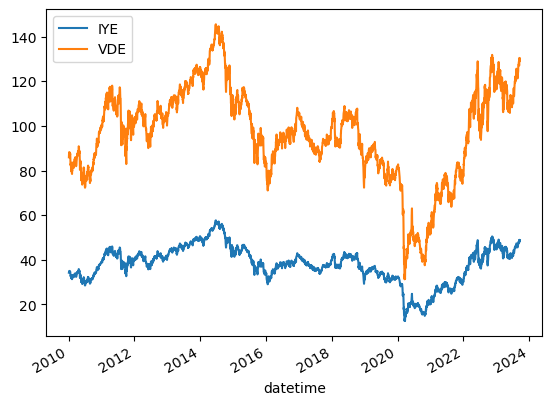

In [7]:
instrument_close_price.plot()

# Split dataset + Fold training dataset

In [8]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(instrument_close_price.sort_index(), test_size=0.2, shuffle=False)

In [9]:
train_dataset

,IYE,VDE
datetime,,
2010-01-04,34.23,85.97
2010-01-05,34.52,86.85
2010-01-06,34.89,87.85
2010-01-07,34.75,87.64
2010-01-08,35.03,88.30
...,...,...
2020-12-11,21.81,55.95
2020-12-14,20.83,54.00
2020-12-15,21.26,55.09


In [10]:
test_dataset

,IYE,VDE
datetime,,
2020-12-18,20.71,53.06
2020-12-21,20.34,52.12
2020-12-22,20.02,51.30
2020-12-23,20.46,52.60
2020-12-24,20.33,52.16
...,...,...
2023-09-12,48.76,130.05
2023-09-13,48.34,129.00
2023-09-14,48.97,130.52


In [12]:
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

# Process for each fold

In [13]:
last_fold =  list(tscv.split(train_dataset))[-1]
(train_index, validation_index) = last_fold

In [14]:
train_data, validation_data = train_dataset.iloc[train_index], train_dataset.iloc[validation_index]

In [15]:
train_data

,IYE,VDE
datetime,,
2010-01-04,34.23,85.97
2010-01-05,34.52,86.85
2010-01-06,34.89,87.85
2010-01-07,34.75,87.64
2010-01-08,35.03,88.30
...,...,...
2019-02-15,36.02,89.28
2019-02-19,36.12,89.62
2019-02-20,36.28,90.04


In [16]:
validation_data

,IYE,VDE
datetime,,
2019-02-25,35.84,88.89
2019-02-26,35.66,88.49
2019-02-27,35.83,88.86
2019-02-28,35.47,88.01
2019-03-01,36.10,89.61
...,...,...
2020-12-11,21.81,55.95
2020-12-14,20.83,54.00
2020-12-15,21.26,55.09


# Calculate parameter(halflife) based on training data

In [17]:
train_data

,IYE,VDE
datetime,,
2010-01-04,34.23,85.97
2010-01-05,34.52,86.85
2010-01-06,34.89,87.85
2010-01-07,34.75,87.64
2010-01-08,35.03,88.30
...,...,...
2019-02-15,36.02,89.28
2019-02-19,36.12,89.62
2019-02-20,36.28,90.04


In [18]:
# x is a dataframe of n series for cointegration analysis
jres = coint_johansen(train_data, det_order=0, k_ar_diff=1)
print(f'Eigen statistic: \n\t{jres.max_eig_stat}')
print(f'Eigen statistic critical: \n\t{jres.max_eig_stat_crit_vals}')
print(f'Eigen vector: \n\t{jres.evec.T}')
print(f'Eigen value: \n\t{jres.eig}')

Eigen statistic: 
	[12.27442312  5.01087774]
Eigen statistic critical: 
	[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
Eigen vector: 
	[[ 2.54667871 -0.98713035]
 [-0.11030451  0.1101151 ]]
Eigen value: 
	[0.00532711 0.00217816]


In [19]:
w1, w2 = jres.evec.T
weights = pd.DataFrame([w1] * len(train_data) , columns=train_data.columns, index=train_data.index)
weights

,IYE,VDE
datetime,,
2010-01-04,2.546679,-0.98713
2010-01-05,2.546679,-0.98713
2010-01-06,2.546679,-0.98713
2010-01-07,2.546679,-0.98713
2010-01-08,2.546679,-0.98713
...,...,...
2019-02-15,2.546679,-0.98713
2019-02-19,2.546679,-0.98713
2019-02-20,2.546679,-0.98713


In [20]:
spread = (weights * train_data).sum(axis=1)
spread

datetime
2010-01-04    2.309217
2010-01-05    2.179079
2010-01-06    2.134220
2010-01-07    1.984982
2010-01-08    2.046546
                ...   
2019-02-15    3.600370
2019-02-19    3.519414
2019-02-20    3.512287
2019-02-21    3.464976
2019-02-22    3.478585
Length: 2300, dtype: float64

In [21]:
zscore_spread = (spread - spread.mean()) / spread.std()
zscore_spread.describe()

count    2300.000000
mean        0.000000
std         1.000000
min        -2.536106
25%        -0.671034
50%         0.249790
75%         0.695480
max         4.203751
dtype: float64

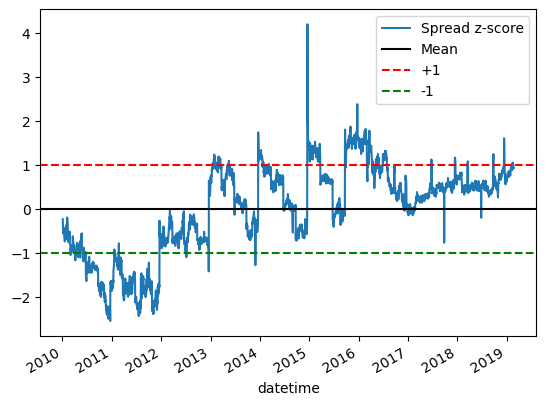

In [22]:
zscore_spread.plot()
plt.axhline(zscore_spread.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["Spread z-score", "Mean", "+1", "-1"]);

In [23]:
x = spread.shift().dropna()
y = spread - spread.shift()
y = y.dropna()
x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
halflife = -math.log(2) / results.params[0]
print('Halflife: %f' % halflife)

Halflife: 46.056597


# Backtest on validation data

In [24]:
lookback = round(halflife)
lookback

46

In [25]:
price = validation_data
price

,IYE,VDE
datetime,,
2019-02-25,35.84,88.89
2019-02-26,35.66,88.49
2019-02-27,35.83,88.86
2019-02-28,35.47,88.01
2019-03-01,36.10,89.61
...,...,...
2020-12-11,21.81,55.95
2020-12-14,20.83,54.00
2020-12-15,21.26,55.09


In [26]:
hedge_ratio = pd.DataFrame(np.NaN,columns=price.columns,index=price.index)
hedge_ratio

,IYE,VDE
datetime,,
2019-02-25,NaN,NaN
2019-02-26,NaN,NaN
2019-02-27,NaN,NaN
2019-02-28,NaN,NaN
2019-03-01,NaN,NaN
...,...,...
2020-12-11,NaN,NaN
2020-12-14,NaN,NaN
2020-12-15,NaN,NaN


In [27]:
for i in range(lookback-1,len(price)):
    price_period = price[i-lookback+1:i+1]
    jres = coint_johansen(price_period, det_order=0, k_ar_diff=1)
    hedge_ratio.iloc[i] = jres.evec.T[0]
hedge_ratio

,IYE,VDE
datetime,,
2019-02-25,NaN,NaN
2019-02-26,NaN,NaN
2019-02-27,NaN,NaN
2019-02-28,NaN,NaN
2019-03-01,NaN,NaN
...,...,...
2020-12-11,10.130956,-3.695280
2020-12-14,13.527464,-5.320746
2020-12-15,14.531347,-5.694031


In [28]:
market_val = hedge_ratio * price
market_val

,IYE,VDE
datetime,,
2019-02-25,NaN,NaN
2019-02-26,NaN,NaN
2019-02-27,NaN,NaN
2019-02-28,NaN,NaN
2019-03-01,NaN,NaN
...,...,...
2020-12-11,220.956145,-206.750915
2020-12-14,281.777066,-287.320278
2020-12-15,308.936447,-313.684149


In [29]:
spread = market_val.sum(axis=1)
spread

datetime
2019-02-25     0.000000
2019-02-26     0.000000
2019-02-27     0.000000
2019-02-28     0.000000
2019-03-01     0.000000
                ...    
2020-12-11    14.205230
2020-12-14    -5.543212
2020-12-15    -4.747702
2020-12-16    -8.658602
2020-12-17    12.108630
Length: 460, dtype: float64

In [30]:
num_units = -(spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()
num_units

datetime
2019-02-25         NaN
2019-02-26         NaN
2019-02-27         NaN
2019-02-28         NaN
2019-03-01         NaN
                ...   
2020-12-11   -0.907350
2020-12-14    0.257143
2020-12-15    0.203942
2020-12-16    0.426206
2020-12-17   -0.777747
Length: 460, dtype: float64

<Axes: xlabel='datetime'>

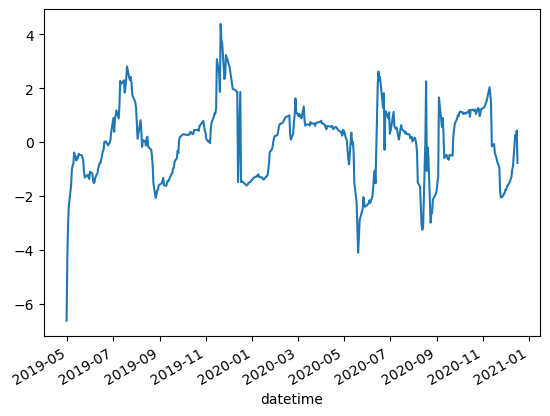

In [31]:
num_units.plot()

In [32]:
positions = market_val.mul(num_units, axis=0)
positions

,IYE,VDE
datetime,,
2019-02-25,NaN,NaN
2019-02-26,NaN,NaN
2019-02-27,NaN,NaN
2019-02-28,NaN,NaN
2019-03-01,NaN,NaN
...,...,...
2020-12-11,-200.484621,187.595502
2020-12-14,72.457049,-73.882448
2020-12-15,63.005100,-63.973356


In [33]:
pnl = positions.shift(1) * (price - price.shift(1)) / price.shift(1)
pnl = pnl.sum(axis=1)
pnl

datetime
2019-02-25    0.000000
2019-02-26    0.000000
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.000000
                ...   
2020-12-11    0.171775
2020-12-14    2.470298
2020-12-15    0.004422
2020-12-16    0.011981
2020-12-17    0.261002
Length: 460, dtype: float64

In [34]:
pnl.describe()

count    460.000000
mean       0.171717
std        1.659059
min       -6.359231
25%       -0.177377
50%        0.000000
75%        0.301968
max       16.332006
dtype: float64

In [35]:
ret = pnl / positions.shift(1).sum(axis=1).abs()
ret

datetime
2019-02-25         NaN
2019-02-26         NaN
2019-02-27         NaN
2019-02-28         NaN
2019-03-01         NaN
                ...   
2020-12-11    0.010723
2020-12-14    0.191658
2020-12-15    0.003102
2020-12-16    0.012374
2020-12-17    0.070726
Length: 460, dtype: float64

In [36]:
ret.describe()

count    414.000000
mean       0.022054
std        0.250492
min       -2.344241
25%       -0.017932
50%        0.002024
75%        0.023969
max        2.201862
dtype: float64

<Axes: xlabel='datetime'>

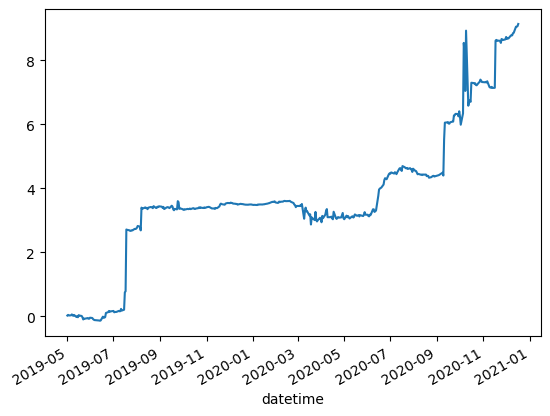

In [37]:
ret.cumsum().plot()

In [38]:
sharp_ratio = math.sqrt(252)*ret.mean()/ret.std()
sharp_ratio

1.397659832153643

In [39]:
term = pd.DataFrame({
    "ret": ret.cumsum().dropna(),
    'lagged_ret': ret.cumsum().dropna().shift(1),
    'high_watermark_index': ret.cumsum().dropna().index
})
term['lagged_ret'] = term['lagged_ret'].fillna(0)

highest_watermark_index = term.iloc[0]['high_watermark_index']
for d in term.index:
    row = term.loc[d]
    if row['ret'] >= term.loc[highest_watermark_index]['ret']:
        highest_watermark_index = d
    term.loc[d, 'high_watermark_index']= highest_watermark_index

term['high_watermark_ret'] = term.apply(lambda x: term.loc[x['high_watermark_index']]['ret'], axis=1)
term['drawdown_deep'] = term['high_watermark_ret'] - term['ret']
term['drawdown_duration'] = term.index - term['high_watermark_index']
term

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
datetime,,,,,,
2019-05-01,0.021137,0.000000,2019-05-01,0.021137,0.000000,0 days
2019-05-02,0.042409,0.021137,2019-05-02,0.042409,0.000000,0 days
2019-05-03,0.023348,0.042409,2019-05-02,0.042409,0.019060,1 days
2019-05-06,0.029103,0.023348,2019-05-02,0.042409,0.013306,4 days
2019-05-07,0.057539,0.029103,2019-05-07,0.057539,0.000000,0 days
...,...,...,...,...,...,...
2020-12-11,8.852654,8.841931,2020-10-09,8.921680,0.069026,63 days
2020-12-14,9.044312,8.852654,2020-12-14,9.044312,0.000000,0 days
2020-12-15,9.047414,9.044312,2020-12-15,9.047414,0.000000,0 days


In [40]:
term.describe()

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
count,414.000000,414.000000,414,414.000000,414.000000,414
mean,3.750928,3.728874,2020-01-19 08:00:00,4.022784,0.271856,35 days 07:07:49.565217391
min,-0.139637,-0.139637,2019-05-01 00:00:00,0.021137,0.000000,0 days 00:00:00
25%,3.129612,3.128601,2019-09-24 00:00:00,3.594932,0.031111,3 days 00:00:00
50%,3.441063,3.436555,2020-02-19 00:00:00,3.603764,0.115466,23 days 12:00:00
75%,4.423690,4.422843,2020-07-17 00:00:00,4.690256,0.306387,55 days 18:00:00
max,9.130513,9.059788,2020-12-17 00:00:00,9.130513,2.344241,139 days 00:00:00
std,2.126549,2.117951,NaN,2.329297,0.425990,36 days 22:13:11.621553344


In [41]:
print(term['drawdown_deep'].idxmax())
term.loc[term['drawdown_deep'].idxmax()]

2020-10-12 00:00:00


ret                                6.577439
lagged_ret                          8.92168
high_watermark_index    2020-10-09 00:00:00
high_watermark_ret                  8.92168
drawdown_deep                      2.344241
drawdown_duration           3 days 00:00:00
Name: 2020-10-12 00:00:00, dtype: object

In [42]:
print(term['drawdown_duration'].idxmax())
term.loc[term['drawdown_duration'].idxmax()]

2020-02-10 00:00:00


ret                                3.580632
lagged_ret                         3.576847
high_watermark_index    2019-09-24 00:00:00
high_watermark_ret                 3.594932
drawdown_deep                      0.014301
drawdown_duration         139 days 00:00:00
Name: 2020-02-10 00:00:00, dtype: object

# Bollinger Band

In [43]:
entry_zscore = 1.5
exit_zscore = 0

In [44]:
zscore_spread = (spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()
zscore_spread.describe()

count    415.000000
mean      -0.006288
std        1.402274
min       -4.384312
25%       -0.874290
50%       -0.257143
75%        1.066555
max        6.634888
dtype: float64

<Axes: xlabel='datetime'>

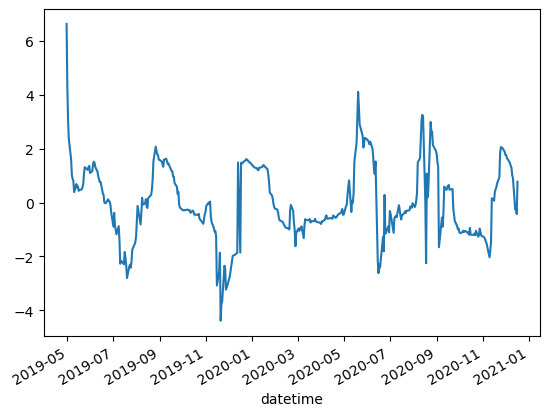

In [45]:
zscore_spread.plot()

In [46]:
long_entry = zscore_spread < -entry_zscore
long_exit = zscore_spread >= exit_zscore
short_entry = zscore_spread > entry_zscore
short_exit = zscore_spread <= exit_zscore

In [47]:
num_unit_longs = pd.Series(np.NaN, index=zscore_spread.index)
num_unit_shorts = pd.Series(np.NaN, index=zscore_spread.index)

<Axes: xlabel='datetime'>

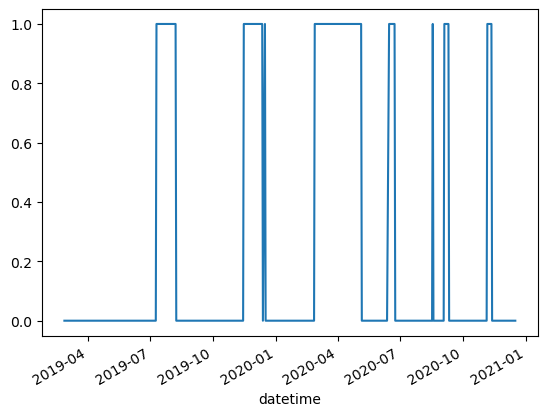

In [48]:
num_unit_longs.iloc[0] = 0
num_unit_longs[long_entry] = 1
num_unit_longs[long_exit] = 0
num_unit_longs = num_unit_longs.fillna(method='ffill')
num_unit_longs.plot()

<Axes: xlabel='datetime'>

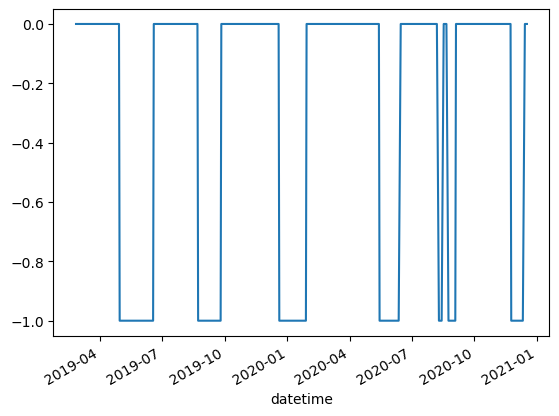

In [49]:
num_unit_shorts.iloc[0] = 0
num_unit_shorts[short_entry] = -1
num_unit_shorts[short_exit] = 0
num_unit_shorts = num_unit_shorts.fillna(method='ffill')
num_unit_shorts.plot()

<Axes: xlabel='datetime'>

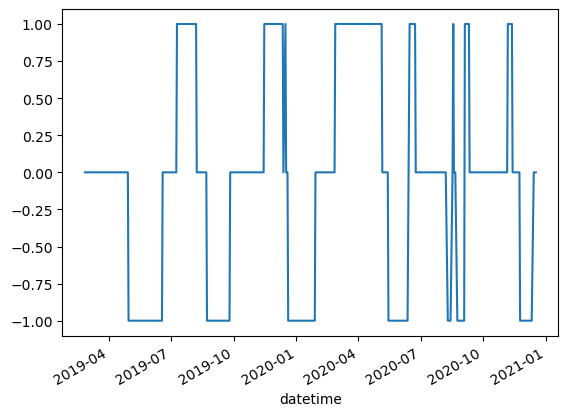

In [50]:
num_unit = num_unit_longs + num_unit_shorts
num_unit.plot()

In [51]:
positions = hedge_ratio.mul(num_unit, axis=0) * price
positions

,IYE,VDE
datetime,,
2019-02-25,NaN,NaN
2019-02-26,NaN,NaN
2019-02-27,NaN,NaN
2019-02-28,NaN,NaN
2019-03-01,NaN,NaN
...,...,...
2020-12-11,-220.956145,206.750915
2020-12-14,0.000000,-0.000000
2020-12-15,0.000000,-0.000000


<Axes: xlabel='datetime'>

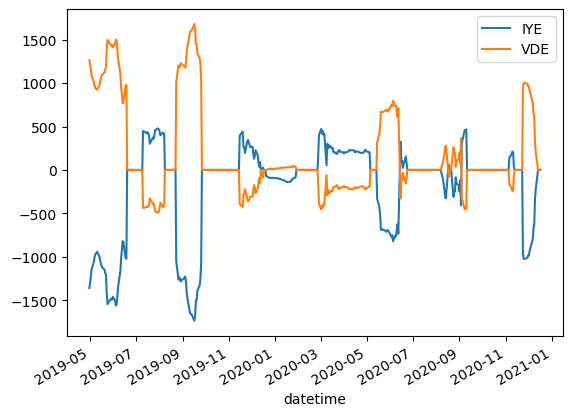

In [52]:
positions.plot()

In [53]:
pnl = positions.shift(1) * (price - price.shift(1))/price.shift(1)
pnl = pnl.sum(axis=1)
pnl.describe()

count    460.000000
mean       0.069440
std        1.245870
min       -8.382238
25%        0.000000
50%        0.000000
75%        0.114274
max       11.287958
dtype: float64

<Axes: xlabel='datetime'>

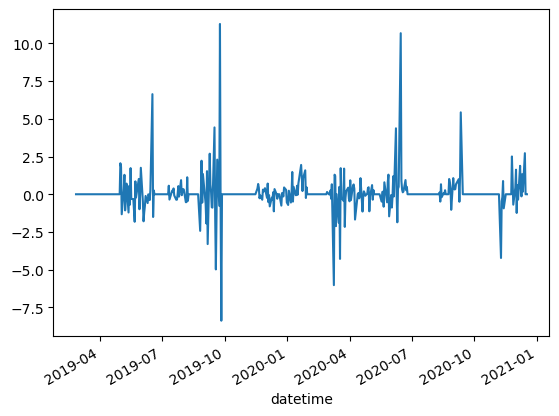

In [54]:
pnl.plot()

In [55]:
ret = pnl / positions.shift(1).sum(axis=1).abs()
ret

datetime
2019-02-25         NaN
2019-02-26         NaN
2019-02-27         NaN
2019-02-28         NaN
2019-03-01         NaN
                ...   
2020-12-11    0.010723
2020-12-14    0.191658
2020-12-15         NaN
2020-12-16         NaN
2020-12-17         NaN
Length: 460, dtype: float64

In [56]:
ret.describe()

count    236.000000
mean       0.025978
std        0.178778
min       -0.460998
25%       -0.016786
50%        0.002210
75%        0.027967
max        1.928874
dtype: float64

<Axes: xlabel='datetime'>

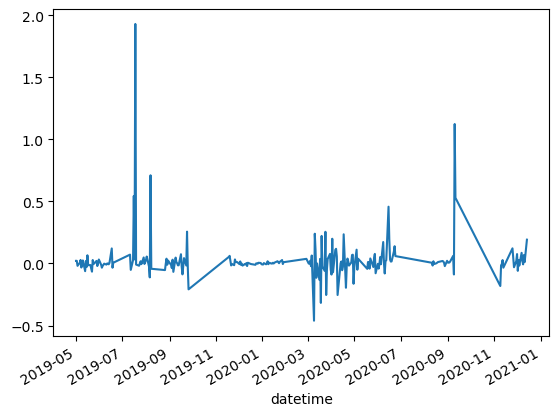

In [57]:
ret.dropna().plot()

<Axes: xlabel='datetime'>

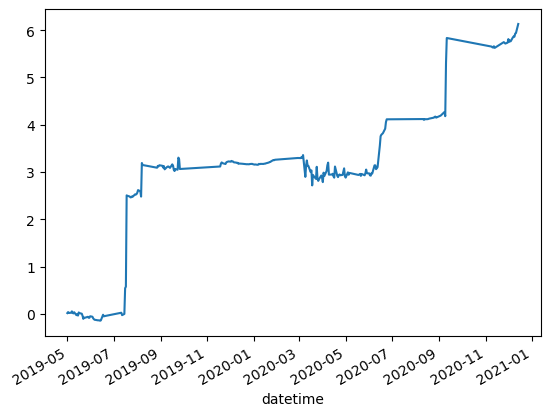

In [58]:
ret.cumsum().dropna().plot()

In [59]:
sharp_ratio = math.sqrt(252)*ret.mean()/ret.std()
sharp_ratio

2.3066763382776334

In [60]:
term = pd.DataFrame({
    "ret": ret.cumsum().dropna(),
    'lagged_ret': ret.cumsum().dropna().shift(1),
    'high_watermark_index': ret.cumsum().dropna().index
})
term['lagged_ret'] = term['lagged_ret'].fillna(0)

highest_watermark_index = term.iloc[0]['high_watermark_index']
for d in term.index:
    row = term.loc[d]
    if row['ret'] >= term.loc[highest_watermark_index]['ret']:
        highest_watermark_index = d
    term.loc[d, 'high_watermark_index']= highest_watermark_index

term['high_watermark_ret'] = term.apply(lambda x: term.loc[x['high_watermark_index']]['ret'], axis=1)
term['drawdown_deep'] = term['high_watermark_ret'] - term['ret']
term['drawdown_duration'] = term.index - term['high_watermark_index']
term

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
datetime,,,,,,
2019-05-01,0.021137,0.000000,2019-05-01,0.021137,0.000000,0 days
2019-05-02,0.042409,0.021137,2019-05-02,0.042409,0.000000,0 days
2019-05-03,0.023348,0.042409,2019-05-02,0.042409,0.019060,1 days
2019-05-06,0.029103,0.023348,2019-05-02,0.042409,0.013306,4 days
2019-05-07,0.057539,0.029103,2019-05-07,0.057539,0.000000,0 days
...,...,...,...,...,...,...
2020-12-08,5.867982,5.848582,2020-12-08,5.867982,0.000000,0 days
2020-12-09,5.860916,5.867982,2020-12-08,5.867982,0.007067,1 days
2020-12-10,5.928346,5.860916,2020-12-10,5.928346,0.000000,0 days


In [61]:
term.describe()

,ret,lagged_ret,high_watermark_index,high_watermark_ret,drawdown_deep,drawdown_duration
count,236.000000,236.000000,236,236.000000,236.000000,236
mean,2.859476,2.833498,2019-12-11 15:51:51.864406784,3.013286,0.153810,42 days 04:46:46.779661017
min,-0.139637,-0.139637,2019-05-01 00:00:00,0.021137,0.000000,0 days 00:00:00
25%,2.858186,2.855854,2019-08-07 00:00:00,3.193108,0.024975,4 days 00:00:00
50%,3.114751,3.109397,2019-09-24 00:00:00,3.306251,0.107693,34 days 00:00:00
75%,3.226797,3.225640,2020-03-06 00:00:00,3.360696,0.216123,73 days 06:00:00
max,6.130727,5.939070,2020-12-14 00:00:00,6.130727,0.640964,161 days 00:00:00
std,1.526316,1.522570,NaN,1.528237,0.154590,39 days 10:18:31.384380026


In [62]:
print(term['drawdown_deep'].idxmax())
term.loc[term['drawdown_deep'].idxmax()]

2020-03-18 00:00:00


ret                                2.719732
lagged_ret                         3.037247
high_watermark_index    2020-03-06 00:00:00
high_watermark_ret                 3.360696
drawdown_deep                      0.640964
drawdown_duration          12 days 00:00:00
Name: 2020-03-18 00:00:00, dtype: object

In [63]:
print(term['drawdown_duration'].idxmax())
term.loc[term['drawdown_duration'].idxmax()]

2020-03-03 00:00:00


ret                                3.296885
lagged_ret                         3.297836
high_watermark_index    2019-09-24 00:00:00
high_watermark_ret                 3.306251
drawdown_deep                      0.009366
drawdown_duration         161 days 00:00:00
Name: 2020-03-03 00:00:00, dtype: object